In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Bidirectional, concatenate, GRU, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [6]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [7]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


## Check by plotting a Spectogram

Pop


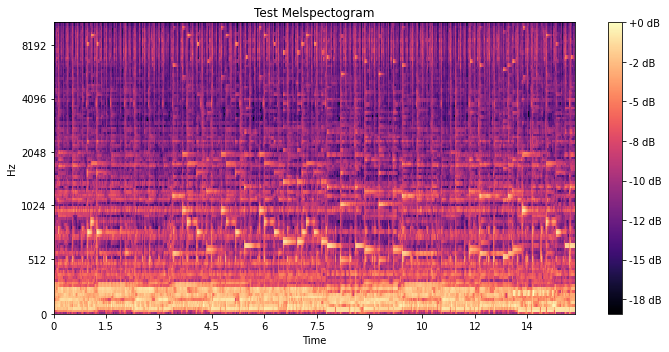

In [8]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [9]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [10]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize_1 = (3,5)
ksize_2 = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

lstm_count = 64

BATCH_SIZE = 64
EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize_1, strides=1, padding='valid', activation='elu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize_2, strides=1, padding='valid', activation='elu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize_2, strides=1, padding='valid', activation='elu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize_2, strides=1, padding='valid', activation='elu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    conv_5 = Conv2D(filters = nb_filters4, kernel_size = ksize_2, strides=1, padding='valid', activation='elu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(pool_size_3)(conv_5)
    
    flatten1 = Flatten()(pool_5)
    
    ### Recurrent Block
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name='pool_lstm')(layer)
    
    # Embedding layer
    squeezed = Lambda(lambda x: K.squeeze(x, axis = -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis = -1, name='concat')
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.0005)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [11]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
       
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_4/model_root/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_4/model_root/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [12]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [13]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [14]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Electronic', 'Pop', 'Hip-Hop', 'Experimental'], ['International', 'Folk', 'Rock', 'Instrumental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 22s 94ms/step - loss: 0.6624 - accuracy: 0.6251 - val_loss: 0.6309 - val_accuracy: 0.6505

Epoch 00001: val_accuracy improved from -inf to 0.65049, saving model to ./models/tree_4/model_root/folder1\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5971 - accuracy: 0.6909 - val_loss: 0.6056 - val_accuracy: 0.6796

Epoch 00002: val_accuracy improved from 0.65049 to 0.67961, saving model to ./models/tree_4/model_root/folder1\model.h5
Epoch 3/30
110/110 [==============================] - 9s 82ms/step - loss: 0.5690 - accuracy: 0.7142 - val_loss: 0.5773 - val_accuracy: 0.7087

Epoch 00003: val_accuracy improved from 0.67961 to 0.70874, saving model to ./models/tree_4/model_root/folder1\model.h5
Epoch 4/30
110/110 [==============================] -

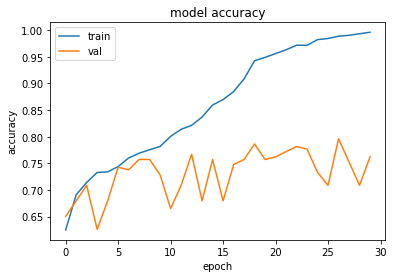

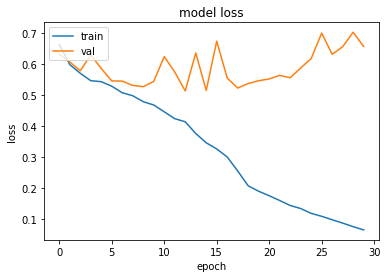

Folder num 2
Genre split [['Electronic', 'International', 'Pop', 'Folk'], ['Hip-Hop', 'Instrumental', 'Experimental', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 13s 91ms/step - loss: 0.6828 - accuracy: 0.5880 - val_loss: 0.6827 - val_accuracy: 0.5631

Epoch 00001: val_accuracy improved from -inf to 0.56311, saving model to ./models/tree_4/model_root/folder2\model.h5
Epoch 2/30
110/110 [==============================] - 9s 82ms/step - loss: 0.6387 - accuracy: 0.6328 - val_loss: 0.6635 - val_accuracy: 0.6117

Epoch 00002: val_accuracy improved from 0.56311 to 0.61165, saving model to ./models/tree_4/model_root/folder2\model.h5
Epoch 3/30
110/110 [==============================] - 9s 82ms/step - loss: 0.6216 - accuracy: 0.6503 - val_loss: 0.6593 - val_accuracy: 0.5971

Epoch 00003: val_accuracy did not improve from 0.61165
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6085 - accuracy: 0.6680 - val_loss: 0.659

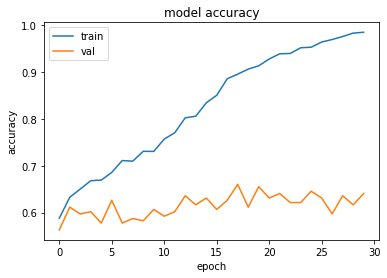

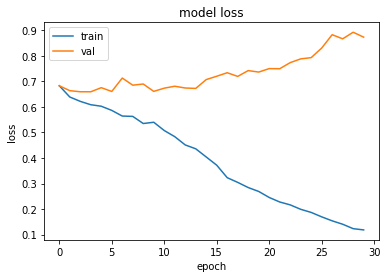

Folder num 3
Genre split [['Hip-Hop', 'Electronic', 'International', 'Rock'], ['Pop', 'Folk', 'Instrumental', 'Experimental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 20s 99ms/step - loss: 0.5922 - accuracy: 0.6816 - val_loss: 0.5450 - val_accuracy: 0.7136

Epoch 00001: val_accuracy improved from -inf to 0.71359, saving model to ./models/tree_4/model_root/folder3\model.h5
Epoch 2/30
110/110 [==============================] - 9s 80ms/step - loss: 0.5440 - accuracy: 0.7257 - val_loss: 0.5327 - val_accuracy: 0.7282

Epoch 00002: val_accuracy improved from 0.71359 to 0.72816, saving model to ./models/tree_4/model_root/folder3\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5301 - accuracy: 0.7361 - val_loss: 0.6062 - val_accuracy: 0.7282

Epoch 00003: val_accuracy did not improve from 0.72816
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5207 - accuracy: 0.7428 - val_loss: 0.522

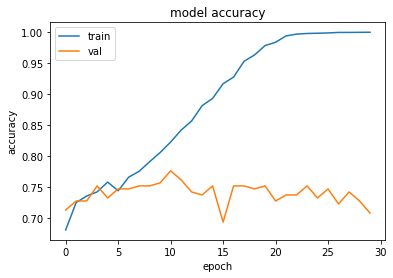

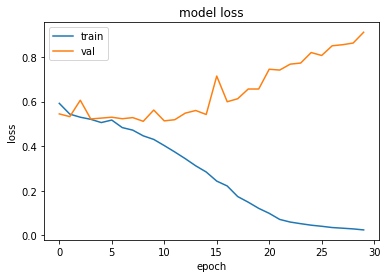

Folder num 4
Genre split [['Experimental', 'International', 'Pop', 'Hip-Hop'], ['Electronic', 'Instrumental', 'Folk', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 26s 87ms/step - loss: 0.6662 - accuracy: 0.5975 - val_loss: 0.6182 - val_accuracy: 0.6553

Epoch 00001: val_accuracy improved from -inf to 0.65534, saving model to ./models/tree_4/model_root/folder4\model.h5
Epoch 2/30
110/110 [==============================] - 9s 80ms/step - loss: 0.6163 - accuracy: 0.6661 - val_loss: 0.6189 - val_accuracy: 0.6359

Epoch 00002: val_accuracy did not improve from 0.65534
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6060 - accuracy: 0.6726 - val_loss: 0.5920 - val_accuracy: 0.7039

Epoch 00003: val_accuracy improved from 0.65534 to 0.70388, saving model to ./models/tree_4/model_root/folder4\model.h5
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5904 - accuracy: 0.6923 - val_loss: 0.589

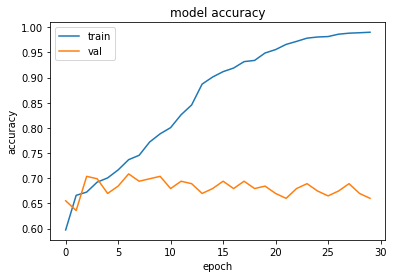

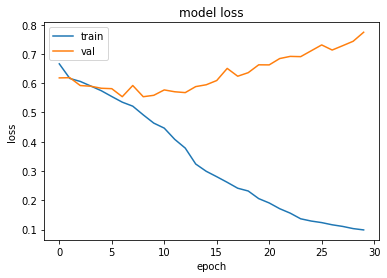

Folder num 5
Genre split [['Experimental', 'Electronic', 'Folk', 'Hip-Hop'], ['Instrumental', 'Pop', 'International', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 22s 169ms/step - loss: 0.6849 - accuracy: 0.5777 - val_loss: 0.6876 - val_accuracy: 0.5825

Epoch 00001: val_accuracy improved from -inf to 0.58252, saving model to ./models/tree_4/model_root/folder5\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6475 - accuracy: 0.6218 - val_loss: 0.6695 - val_accuracy: 0.6214

Epoch 00002: val_accuracy improved from 0.58252 to 0.62136, saving model to ./models/tree_4/model_root/folder5\model.h5
Epoch 3/30
110/110 [==============================] - 9s 80ms/step - loss: 0.6282 - accuracy: 0.6452 - val_loss: 0.6470 - val_accuracy: 0.6019

Epoch 00003: val_accuracy did not improve from 0.62136
Epoch 4/30
110/110 [==============================] - 9s 80ms/step - loss: 0.6093 - accuracy: 0.6637 - val_loss: 0.64

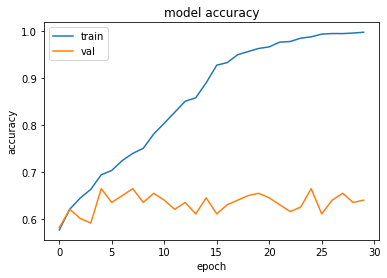

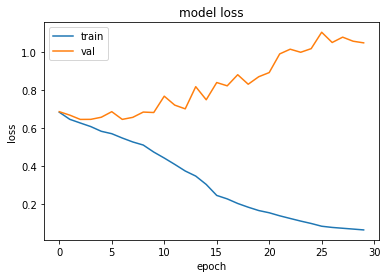

Folder num 6
Genre split [['Rock', 'International', 'Pop', 'Experimental'], ['Hip-Hop', 'Instrumental', 'Folk', 'Electronic']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 13s 88ms/step - loss: 0.6510 - accuracy: 0.6265 - val_loss: 0.6159 - val_accuracy: 0.6699

Epoch 00001: val_accuracy improved from -inf to 0.66990, saving model to ./models/tree_4/model_root/folder6\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6140 - accuracy: 0.6600 - val_loss: 0.6085 - val_accuracy: 0.6990

Epoch 00002: val_accuracy improved from 0.66990 to 0.69903, saving model to ./models/tree_4/model_root/folder6\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5996 - accuracy: 0.6740 - val_loss: 0.5912 - val_accuracy: 0.6796

Epoch 00003: val_accuracy did not improve from 0.69903
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5872 - accuracy: 0.6840 - val_loss: 0.598

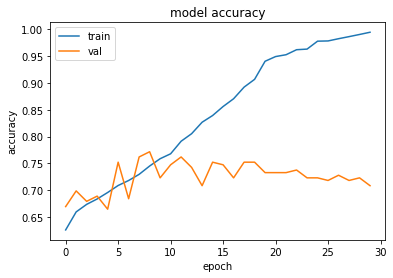

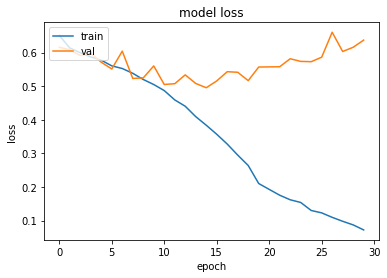

Folder num 7
Genre split [['Electronic', 'Hip-Hop', 'Pop', 'Folk'], ['International', 'Instrumental', 'Rock', 'Experimental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 20s 114ms/step - loss: 0.6918 - accuracy: 0.6120 - val_loss: 0.6030 - val_accuracy: 0.6505

Epoch 00001: val_accuracy improved from -inf to 0.65049, saving model to ./models/tree_4/model_root/folder7\model.h5
Epoch 2/30
110/110 [==============================] - 9s 80ms/step - loss: 0.6270 - accuracy: 0.6568 - val_loss: 0.6011 - val_accuracy: 0.7184

Epoch 00002: val_accuracy improved from 0.65049 to 0.71845, saving model to ./models/tree_4/model_root/folder7\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6107 - accuracy: 0.6724 - val_loss: 0.5963 - val_accuracy: 0.7039

Epoch 00003: val_accuracy did not improve from 0.71845
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5973 - accuracy: 0.6863 - val_loss: 0.56

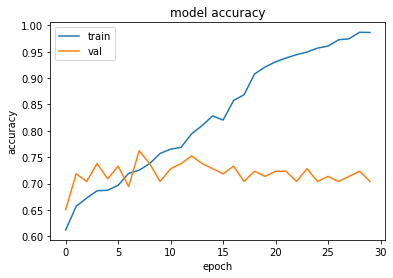

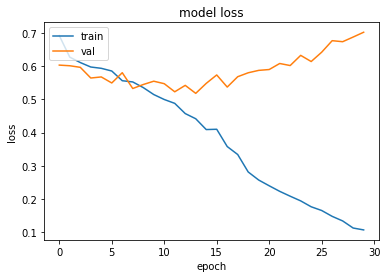

Folder num 8
Genre split [['Rock', 'Hip-Hop', 'Instrumental', 'Experimental'], ['Electronic', 'Pop', 'International', 'Folk']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 16s 87ms/step - loss: 0.6665 - accuracy: 0.5996 - val_loss: 0.6179 - val_accuracy: 0.6505

Epoch 00001: val_accuracy improved from -inf to 0.65049, saving model to ./models/tree_4/model_root/folder8\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6341 - accuracy: 0.6319 - val_loss: 0.5972 - val_accuracy: 0.6845

Epoch 00002: val_accuracy improved from 0.65049 to 0.68447, saving model to ./models/tree_4/model_root/folder8\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6155 - accuracy: 0.6525 - val_loss: 0.5896 - val_accuracy: 0.7039

Epoch 00003: val_accuracy improved from 0.68447 to 0.70388, saving model to ./models/tree_4/model_root/folder8\model.h5
Epoch 4/30
110/110 [==============================] -

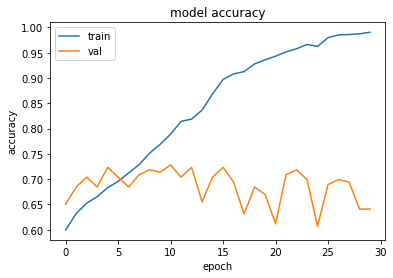

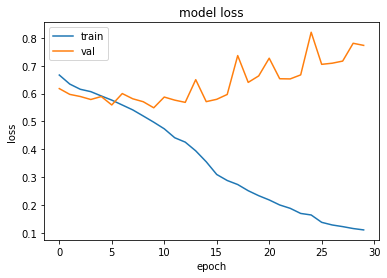

Folder num 9
Genre split [['International', 'Rock', 'Electronic', 'Hip-Hop'], ['Instrumental', 'Folk', 'Experimental', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 17s 124ms/step - loss: 0.6201 - accuracy: 0.6523 - val_loss: 0.6220 - val_accuracy: 0.6408

Epoch 00001: val_accuracy improved from -inf to 0.64078, saving model to ./models/tree_4/model_root/folder9\model.h5
Epoch 2/30
110/110 [==============================] - 9s 82ms/step - loss: 0.5652 - accuracy: 0.7108 - val_loss: 0.6345 - val_accuracy: 0.6553

Epoch 00002: val_accuracy improved from 0.64078 to 0.65534, saving model to ./models/tree_4/model_root/folder9\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5538 - accuracy: 0.7167 - val_loss: 0.6811 - val_accuracy: 0.6165

Epoch 00003: val_accuracy did not improve from 0.65534
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5533 - accuracy: 0.7189 - val_loss: 0.58

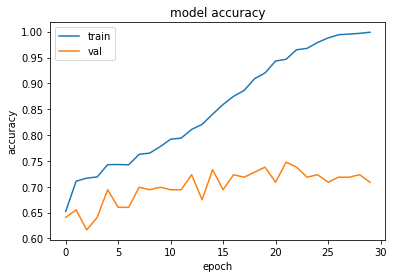

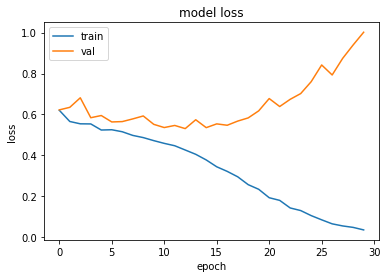

Folder num 10
Genre split [['Experimental', 'Pop', 'Electronic', 'Instrumental'], ['International', 'Folk', 'Hip-Hop', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 13s 89ms/step - loss: 0.6715 - accuracy: 0.5910 - val_loss: 0.6444 - val_accuracy: 0.6068

Epoch 00001: val_accuracy improved from -inf to 0.60680, saving model to ./models/tree_4/model_root/folder10\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6316 - accuracy: 0.6398 - val_loss: 0.6107 - val_accuracy: 0.6553

Epoch 00002: val_accuracy improved from 0.60680 to 0.65534, saving model to ./models/tree_4/model_root/folder10\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6168 - accuracy: 0.6588 - val_loss: 0.5924 - val_accuracy: 0.6796

Epoch 00003: val_accuracy improved from 0.65534 to 0.67961, saving model to ./models/tree_4/model_root/folder10\model.h5
Epoch 4/30
110/110 [=============================

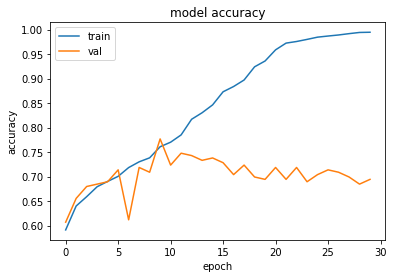

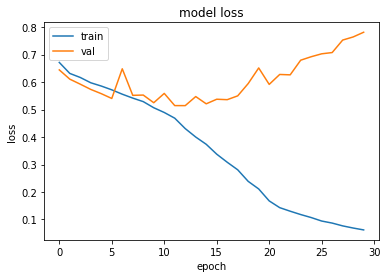

Folder num 11
Genre split [['International', 'Pop', 'Rock', 'Hip-Hop'], ['Experimental', 'Instrumental', 'Folk', 'Electronic']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 18s 88ms/step - loss: 0.6370 - accuracy: 0.6359 - val_loss: 0.5791 - val_accuracy: 0.6893

Epoch 00001: val_accuracy improved from -inf to 0.68932, saving model to ./models/tree_4/model_root/folder11\model.h5
Epoch 2/30
110/110 [==============================] - 10s 92ms/step - loss: 0.5979 - accuracy: 0.6739 - val_loss: 0.5758 - val_accuracy: 0.6990

Epoch 00002: val_accuracy improved from 0.68932 to 0.69903, saving model to ./models/tree_4/model_root/folder11\model.h5
Epoch 3/30
110/110 [==============================] - 9s 82ms/step - loss: 0.5828 - accuracy: 0.6900 - val_loss: 0.5428 - val_accuracy: 0.7184

Epoch 00003: val_accuracy improved from 0.69903 to 0.71845, saving model to ./models/tree_4/model_root/folder11\model.h5
Epoch 4/30
110/110 [============================

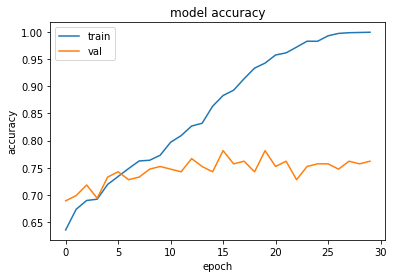

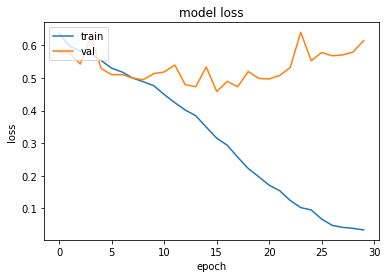

Folder num 12
Genre split [['Instrumental', 'Hip-Hop', 'Pop', 'Rock'], ['Experimental', 'Folk', 'International', 'Electronic']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 15s 87ms/step - loss: 0.6994 - accuracy: 0.5557 - val_loss: 0.6529 - val_accuracy: 0.5971

Epoch 00001: val_accuracy improved from -inf to 0.59709, saving model to ./models/tree_4/model_root/folder12\model.h5
Epoch 2/30
110/110 [==============================] - 9s 80ms/step - loss: 0.6691 - accuracy: 0.5860 - val_loss: 0.6476 - val_accuracy: 0.6359

Epoch 00002: val_accuracy improved from 0.59709 to 0.63592, saving model to ./models/tree_4/model_root/folder12\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6530 - accuracy: 0.6056 - val_loss: 0.6436 - val_accuracy: 0.6214

Epoch 00003: val_accuracy did not improve from 0.63592
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6416 - accuracy: 0.6288 - val_loss: 0.

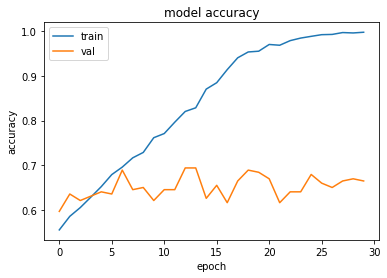

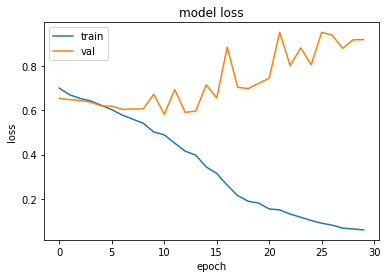

Folder num 13
Genre split [['Experimental', 'Hip-Hop', 'Folk', 'International'], ['Electronic', 'Instrumental', 'Rock', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 13s 89ms/step - loss: 0.6817 - accuracy: 0.5744 - val_loss: 0.6418 - val_accuracy: 0.6505

Epoch 00001: val_accuracy improved from -inf to 0.65049, saving model to ./models/tree_4/model_root/folder13\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6441 - accuracy: 0.6212 - val_loss: 0.7278 - val_accuracy: 0.5194

Epoch 00002: val_accuracy did not improve from 0.65049
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6200 - accuracy: 0.6513 - val_loss: 0.6115 - val_accuracy: 0.6845

Epoch 00003: val_accuracy improved from 0.65049 to 0.68447, saving model to ./models/tree_4/model_root/folder13\model.h5
Epoch 4/30
110/110 [==============================] - 12s 106ms/step - loss: 0.6115 - accuracy: 0.6580 - val_loss: 

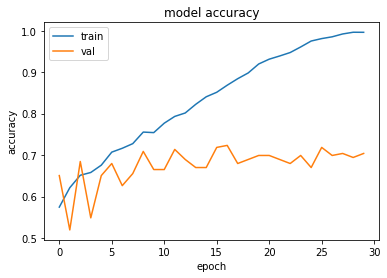

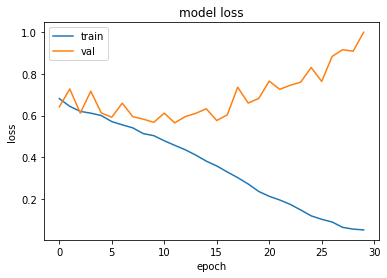

Folder num 14
Genre split [['Instrumental', 'Pop', 'International', 'Experimental'], ['Electronic', 'Hip-Hop', 'Folk', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 12s 88ms/step - loss: 0.6794 - accuracy: 0.5904 - val_loss: 0.6304 - val_accuracy: 0.6165

Epoch 00001: val_accuracy improved from -inf to 0.61650, saving model to ./models/tree_4/model_root/folder14\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6339 - accuracy: 0.6437 - val_loss: 0.6340 - val_accuracy: 0.6117

Epoch 00002: val_accuracy did not improve from 0.61650
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6205 - accuracy: 0.6537 - val_loss: 0.6068 - val_accuracy: 0.6602

Epoch 00003: val_accuracy improved from 0.61650 to 0.66019, saving model to ./models/tree_4/model_root/folder14\model.h5
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6085 - accuracy: 0.6666 - val_loss: 0.

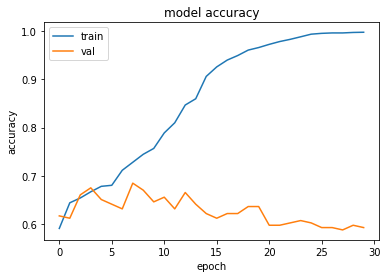

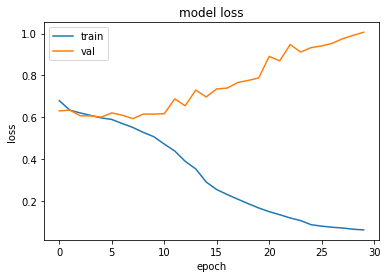

Folder num 15
Genre split [['Pop', 'Folk', 'International', 'Rock'], ['Electronic', 'Experimental', 'Hip-Hop', 'Instrumental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 14s 88ms/step - loss: 0.6541 - accuracy: 0.6212 - val_loss: 0.6297 - val_accuracy: 0.6408

Epoch 00001: val_accuracy improved from -inf to 0.64078, saving model to ./models/tree_4/model_root/folder15\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6036 - accuracy: 0.6817 - val_loss: 0.5915 - val_accuracy: 0.6796

Epoch 00002: val_accuracy improved from 0.64078 to 0.67961, saving model to ./models/tree_4/model_root/folder15\model.h5
Epoch 3/30
110/110 [==============================] - 9s 80ms/step - loss: 0.5684 - accuracy: 0.7182 - val_loss: 0.5653 - val_accuracy: 0.7282

Epoch 00003: val_accuracy improved from 0.67961 to 0.72816, saving model to ./models/tree_4/model_root/folder15\model.h5
Epoch 4/30
110/110 [=============================

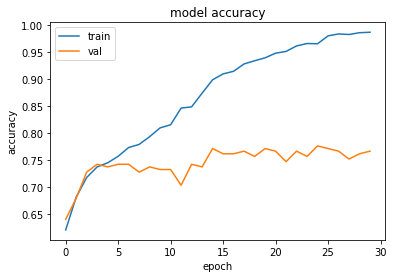

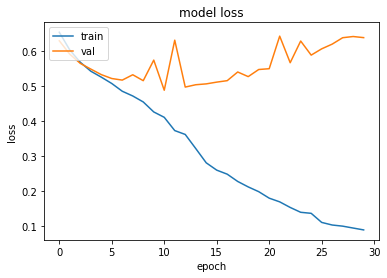

Folder num 16
Genre split [['Electronic', 'Instrumental', 'International', 'Hip-Hop'], ['Pop', 'Folk', 'Rock', 'Experimental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 15s 87ms/step - loss: 0.6522 - accuracy: 0.6246 - val_loss: 0.5916 - val_accuracy: 0.6942

Epoch 00001: val_accuracy improved from -inf to 0.69417, saving model to ./models/tree_4/model_root/folder16\model.h5
Epoch 2/30
110/110 [==============================] - 9s 80ms/step - loss: 0.5977 - accuracy: 0.6846 - val_loss: 0.5984 - val_accuracy: 0.6796

Epoch 00002: val_accuracy did not improve from 0.69417
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5726 - accuracy: 0.7099 - val_loss: 0.5783 - val_accuracy: 0.6796

Epoch 00003: val_accuracy did not improve from 0.69417
Epoch 4/30
110/110 [==============================] - 10s 91ms/step - loss: 0.5532 - accuracy: 0.7252 - val_loss: 0.5733 - val_accuracy: 0.7282

Epoch 00004: val_accuracy improved f

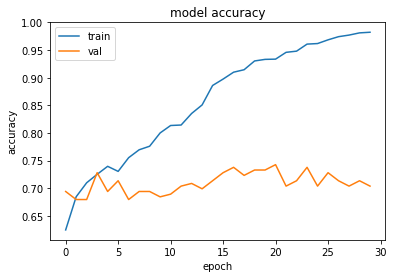

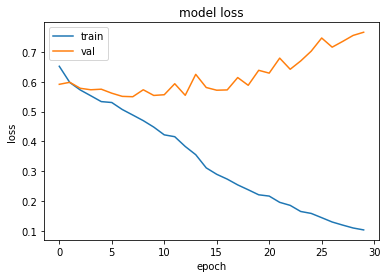

Folder num 17
Genre split [['Folk', 'Instrumental', 'Pop', 'Electronic'], ['Experimental', 'Hip-Hop', 'Rock', 'International']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 14s 92ms/step - loss: 0.6515 - accuracy: 0.6202 - val_loss: 0.7285 - val_accuracy: 0.5680

Epoch 00001: val_accuracy improved from -inf to 0.56796, saving model to ./models/tree_4/model_root/folder17\model.h5
Epoch 2/30
110/110 [==============================] - 9s 83ms/step - loss: 0.6200 - accuracy: 0.6598 - val_loss: 0.6622 - val_accuracy: 0.6214

Epoch 00002: val_accuracy improved from 0.56796 to 0.62136, saving model to ./models/tree_4/model_root/folder17\model.h5
Epoch 3/30
110/110 [==============================] - 10s 94ms/step - loss: 0.5943 - accuracy: 0.6873 - val_loss: 0.6332 - val_accuracy: 0.6699

Epoch 00003: val_accuracy improved from 0.62136 to 0.66990, saving model to ./models/tree_4/model_root/folder17\model.h5
Epoch 4/30
110/110 [============================

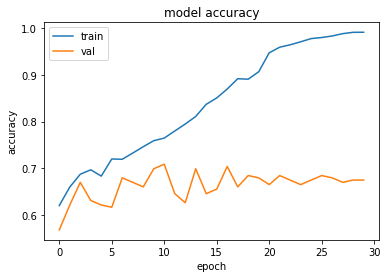

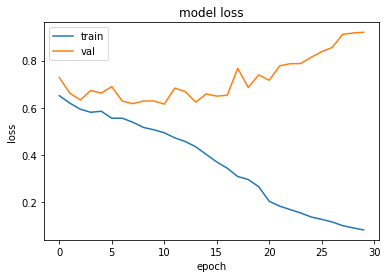

Folder num 18
Genre split [['Instrumental', 'International', 'Experimental', 'Folk'], ['Hip-Hop', 'Rock', 'Electronic', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 18s 128ms/step - loss: 0.6304 - accuracy: 0.6636 - val_loss: 0.5996 - val_accuracy: 0.7184

Epoch 00001: val_accuracy improved from -inf to 0.71845, saving model to ./models/tree_4/model_root/folder18\model.h5
Epoch 2/30
110/110 [==============================] - 9s 82ms/step - loss: 0.5612 - accuracy: 0.7145 - val_loss: 0.5770 - val_accuracy: 0.7282

Epoch 00002: val_accuracy improved from 0.71845 to 0.72816, saving model to ./models/tree_4/model_root/folder18\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5470 - accuracy: 0.7317 - val_loss: 0.5660 - val_accuracy: 0.7282

Epoch 00003: val_accuracy did not improve from 0.72816
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5324 - accuracy: 0.7380 - val_loss: 0

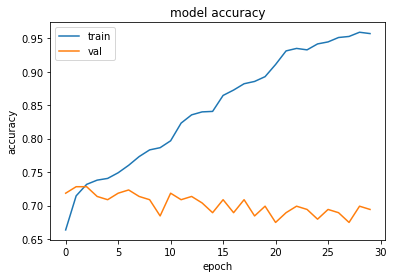

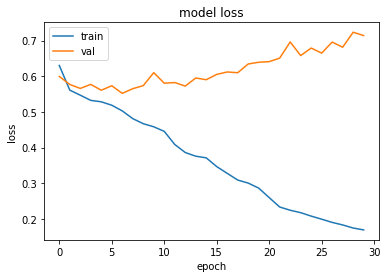

Folder num 19
Genre split [['Experimental', 'International', 'Hip-Hop', 'Rock'], ['Electronic', 'Folk', 'Instrumental', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 16s 88ms/step - loss: 0.6981 - accuracy: 0.5830 - val_loss: 0.6347 - val_accuracy: 0.6408

Epoch 00001: val_accuracy improved from -inf to 0.64078, saving model to ./models/tree_4/model_root/folder19\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6215 - accuracy: 0.6528 - val_loss: 0.6341 - val_accuracy: 0.6359

Epoch 00002: val_accuracy did not improve from 0.64078
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5997 - accuracy: 0.6777 - val_loss: 0.6195 - val_accuracy: 0.6699

Epoch 00003: val_accuracy improved from 0.64078 to 0.66990, saving model to ./models/tree_4/model_root/folder19\model.h5
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5930 - accuracy: 0.6869 - val_loss: 0.

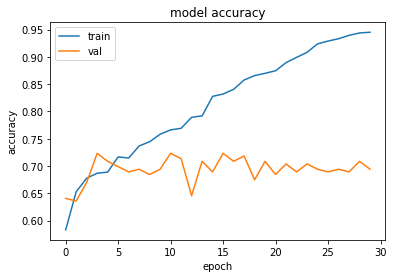

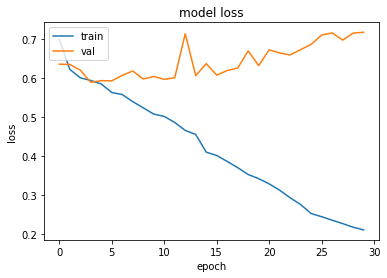

Folder num 20
Genre split [['Electronic', 'Hip-Hop', 'Folk', 'Instrumental'], ['Pop', 'Experimental', 'International', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 15s 92ms/step - loss: 0.6450 - accuracy: 0.6376 - val_loss: 0.7139 - val_accuracy: 0.5756

Epoch 00001: val_accuracy improved from -inf to 0.57561, saving model to ./models/tree_4/model_root/folder20\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6072 - accuracy: 0.6658 - val_loss: 0.6047 - val_accuracy: 0.6634

Epoch 00002: val_accuracy improved from 0.57561 to 0.66341, saving model to ./models/tree_4/model_root/folder20\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5877 - accuracy: 0.6895 - val_loss: 0.6452 - val_accuracy: 0.6585

Epoch 00003: val_accuracy did not improve from 0.66341
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5700 - accuracy: 0.7090 - val_loss: 0.

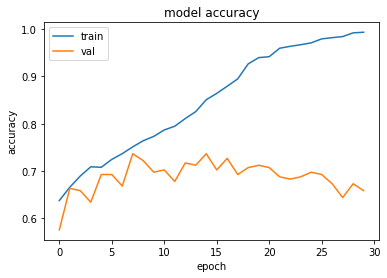

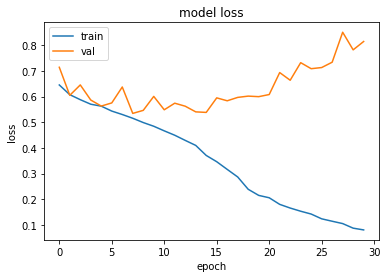

Folder num 21
Genre split [['Hip-Hop', 'Rock', 'Pop', 'Electronic'], ['Instrumental', 'Experimental', 'Folk', 'International']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 13s 90ms/step - loss: 0.6091 - accuracy: 0.6701 - val_loss: 0.5967 - val_accuracy: 0.6732

Epoch 00001: val_accuracy improved from -inf to 0.67317, saving model to ./models/tree_4/model_root/folder21\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5549 - accuracy: 0.7216 - val_loss: 0.5872 - val_accuracy: 0.7073

Epoch 00002: val_accuracy improved from 0.67317 to 0.70732, saving model to ./models/tree_4/model_root/folder21\model.h5
Epoch 3/30
110/110 [==============================] - 12s 111ms/step - loss: 0.5456 - accuracy: 0.7254 - val_loss: 0.5945 - val_accuracy: 0.7122

Epoch 00003: val_accuracy improved from 0.70732 to 0.71220, saving model to ./models/tree_4/model_root/folder21\model.h5
Epoch 4/30
110/110 [===========================

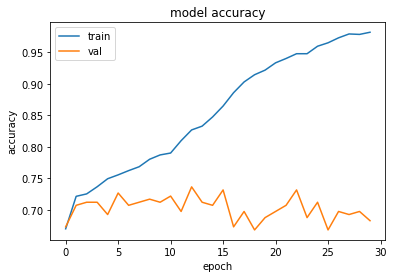

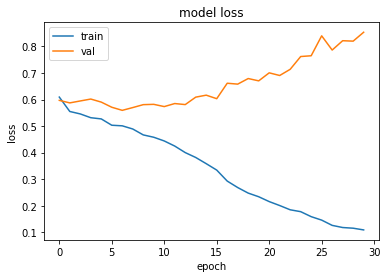

Folder num 22
Genre split [['International', 'Electronic', 'Instrumental', 'Experimental'], ['Hip-Hop', 'Pop', 'Rock', 'Folk']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 12s 88ms/step - loss: 0.6848 - accuracy: 0.5789 - val_loss: 0.6458 - val_accuracy: 0.6293

Epoch 00001: val_accuracy improved from -inf to 0.62927, saving model to ./models/tree_4/model_root/folder22\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6283 - accuracy: 0.6450 - val_loss: 0.6523 - val_accuracy: 0.6341

Epoch 00002: val_accuracy improved from 0.62927 to 0.63415, saving model to ./models/tree_4/model_root/folder22\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6045 - accuracy: 0.6776 - val_loss: 0.6063 - val_accuracy: 0.6878

Epoch 00003: val_accuracy improved from 0.63415 to 0.68780, saving model to ./models/tree_4/model_root/folder22\model.h5
Epoch 4/30
110/110 [=============================

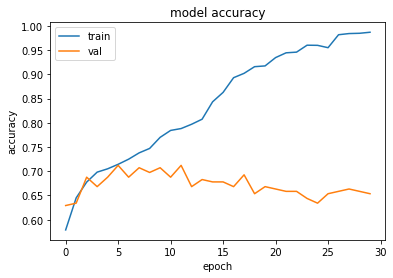

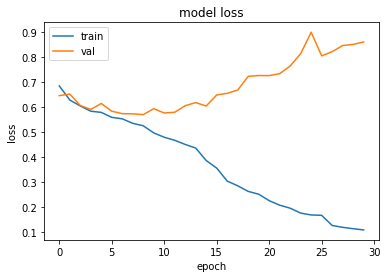

Folder num 23
Genre split [['Hip-Hop', 'Pop', 'Electronic', 'Instrumental'], ['Folk', 'Experimental', 'Rock', 'International']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 14s 88ms/step - loss: 0.6694 - accuracy: 0.5988 - val_loss: 0.7205 - val_accuracy: 0.5561

Epoch 00001: val_accuracy improved from -inf to 0.55610, saving model to ./models/tree_4/model_root/folder23\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6154 - accuracy: 0.6618 - val_loss: 0.6156 - val_accuracy: 0.6634

Epoch 00002: val_accuracy improved from 0.55610 to 0.66341, saving model to ./models/tree_4/model_root/folder23\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5897 - accuracy: 0.6917 - val_loss: 0.6154 - val_accuracy: 0.6585

Epoch 00003: val_accuracy did not improve from 0.66341
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5810 - accuracy: 0.7001 - val_loss: 0.

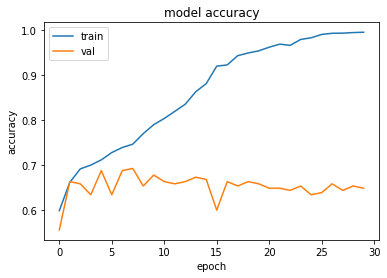

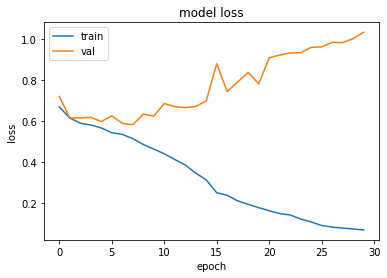

Folder num 24
Genre split [['Rock', 'Pop', 'Experimental', 'Electronic'], ['International', 'Instrumental', 'Folk', 'Hip-Hop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 14s 88ms/step - loss: 0.6649 - accuracy: 0.6092 - val_loss: 0.6215 - val_accuracy: 0.6537

Epoch 00001: val_accuracy improved from -inf to 0.65366, saving model to ./models/tree_4/model_root/folder24\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6142 - accuracy: 0.6550 - val_loss: 0.6267 - val_accuracy: 0.6878

Epoch 00002: val_accuracy improved from 0.65366 to 0.68780, saving model to ./models/tree_4/model_root/folder24\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5926 - accuracy: 0.6786 - val_loss: 0.5842 - val_accuracy: 0.6488

Epoch 00003: val_accuracy did not improve from 0.68780
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5821 - accuracy: 0.6905 - val_loss: 0.

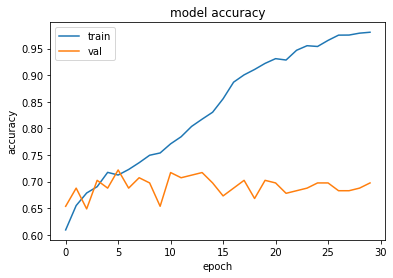

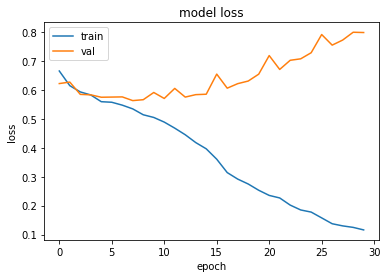

Folder num 25
Genre split [['Hip-Hop', 'Rock', 'Electronic', 'Folk'], ['International', 'Instrumental', 'Pop', 'Experimental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 13s 91ms/step - loss: 0.6673 - accuracy: 0.6050 - val_loss: 0.6059 - val_accuracy: 0.6634

Epoch 00001: val_accuracy improved from -inf to 0.66341, saving model to ./models/tree_4/model_root/folder25\model.h5
Epoch 2/30
110/110 [==============================] - 12s 111ms/step - loss: 0.6260 - accuracy: 0.6479 - val_loss: 0.6473 - val_accuracy: 0.6293

Epoch 00002: val_accuracy did not improve from 0.66341
Epoch 3/30
110/110 [==============================] - 9s 85ms/step - loss: 0.6223 - accuracy: 0.6499 - val_loss: 0.6245 - val_accuracy: 0.6439

Epoch 00003: val_accuracy did not improve from 0.66341
Epoch 4/30
110/110 [==============================] - 9s 82ms/step - loss: 0.6129 - accuracy: 0.6642 - val_loss: 0.5939 - val_accuracy: 0.6878

Epoch 00004: val_accuracy improved 

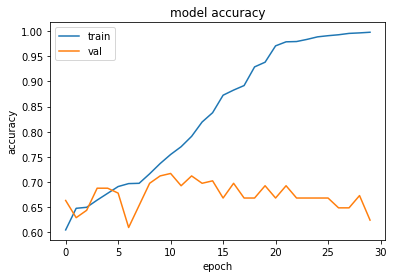

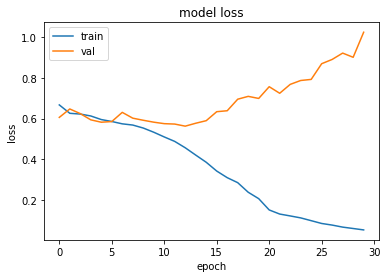

Folder num 26
Genre split [['Rock', 'Pop', 'Electronic', 'Folk'], ['International', 'Instrumental', 'Experimental', 'Hip-Hop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 12s 89ms/step - loss: 0.6937 - accuracy: 0.5652 - val_loss: 0.6694 - val_accuracy: 0.5805

Epoch 00001: val_accuracy improved from -inf to 0.58049, saving model to ./models/tree_4/model_root/folder26\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6363 - accuracy: 0.6389 - val_loss: 0.6573 - val_accuracy: 0.6098

Epoch 00002: val_accuracy improved from 0.58049 to 0.60976, saving model to ./models/tree_4/model_root/folder26\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6269 - accuracy: 0.6533 - val_loss: 0.6400 - val_accuracy: 0.6341

Epoch 00003: val_accuracy improved from 0.60976 to 0.63415, saving model to ./models/tree_4/model_root/folder26\model.h5
Epoch 4/30
110/110 [=============================

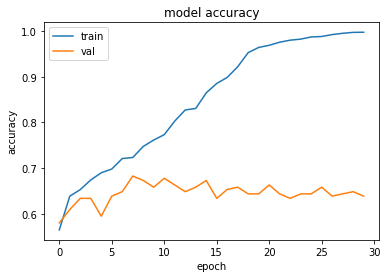

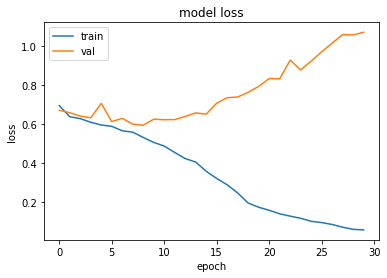

Folder num 27
Genre split [['Experimental', 'Electronic', 'Instrumental', 'International'], ['Pop', 'Folk', 'Hip-Hop', 'Rock']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 26s 98ms/step - loss: 0.6729 - accuracy: 0.5898 - val_loss: 0.6812 - val_accuracy: 0.5805

Epoch 00001: val_accuracy improved from -inf to 0.58049, saving model to ./models/tree_4/model_root/folder27\model.h5
Epoch 2/30
110/110 [==============================] - 9s 80ms/step - loss: 0.6278 - accuracy: 0.6456 - val_loss: 0.6804 - val_accuracy: 0.5854

Epoch 00002: val_accuracy improved from 0.58049 to 0.58537, saving model to ./models/tree_4/model_root/folder27\model.h5
Epoch 3/30
110/110 [==============================] - 9s 80ms/step - loss: 0.6119 - accuracy: 0.6663 - val_loss: 0.6430 - val_accuracy: 0.6585

Epoch 00003: val_accuracy improved from 0.58537 to 0.65854, saving model to ./models/tree_4/model_root/folder27\model.h5
Epoch 4/30
110/110 [=============================

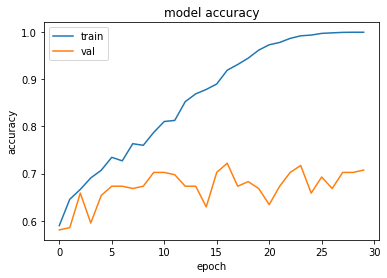

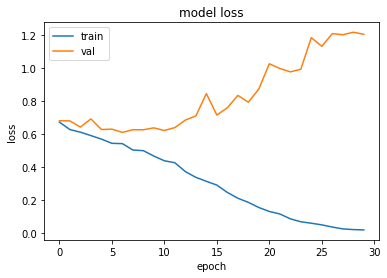

Folder num 28
Genre split [['Rock', 'Pop', 'International', 'Hip-Hop'], ['Experimental', 'Electronic', 'Folk', 'Instrumental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 21s 99ms/step - loss: 0.6311 - accuracy: 0.6437 - val_loss: 0.7402 - val_accuracy: 0.5902

Epoch 00001: val_accuracy improved from -inf to 0.59024, saving model to ./models/tree_4/model_root/folder28\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5949 - accuracy: 0.6794 - val_loss: 0.6193 - val_accuracy: 0.6098

Epoch 00002: val_accuracy improved from 0.59024 to 0.60976, saving model to ./models/tree_4/model_root/folder28\model.h5
Epoch 3/30
110/110 [==============================] - 9s 80ms/step - loss: 0.5640 - accuracy: 0.7078 - val_loss: 0.6289 - val_accuracy: 0.6244

Epoch 00003: val_accuracy improved from 0.60976 to 0.62439, saving model to ./models/tree_4/model_root/folder28\model.h5
Epoch 4/30
110/110 [=============================

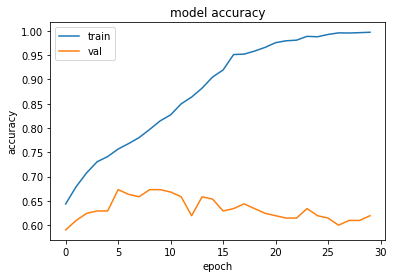

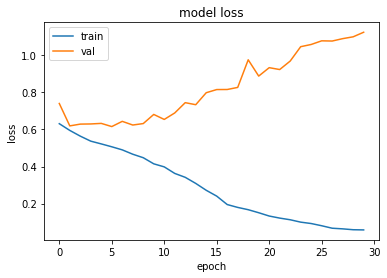

Folder num 29
Genre split [['Instrumental', 'Electronic', 'Hip-Hop', 'Rock'], ['Pop', 'Folk', 'Experimental', 'International']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 13s 89ms/step - loss: 0.6682 - accuracy: 0.5951 - val_loss: 0.6737 - val_accuracy: 0.5902

Epoch 00001: val_accuracy improved from -inf to 0.59024, saving model to ./models/tree_4/model_root/folder29\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6242 - accuracy: 0.6452 - val_loss: 0.6831 - val_accuracy: 0.5805

Epoch 00002: val_accuracy did not improve from 0.59024
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6080 - accuracy: 0.6686 - val_loss: 0.6262 - val_accuracy: 0.6585

Epoch 00003: val_accuracy improved from 0.59024 to 0.65854, saving model to ./models/tree_4/model_root/folder29\model.h5
Epoch 4/30
110/110 [==============================] - 9s 82ms/step - loss: 0.5949 - accuracy: 0.6782 - val_loss: 0.

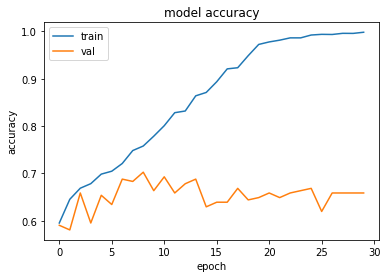

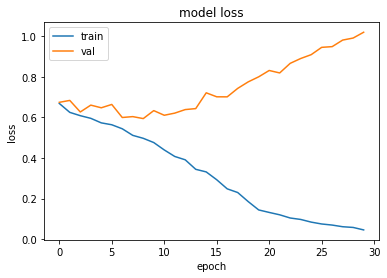

Folder num 30
Genre split [['Rock', 'International', 'Folk', 'Pop'], ['Electronic', 'Hip-Hop', 'Experimental', 'Instrumental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 21s 134ms/step - loss: 0.6532 - accuracy: 0.6260 - val_loss: 0.5735 - val_accuracy: 0.7317

Epoch 00001: val_accuracy improved from -inf to 0.73171, saving model to ./models/tree_4/model_root/folder30\model.h5
Epoch 2/30
110/110 [==============================] - 9s 80ms/step - loss: 0.5941 - accuracy: 0.6902 - val_loss: 0.5276 - val_accuracy: 0.7463

Epoch 00002: val_accuracy improved from 0.73171 to 0.74634, saving model to ./models/tree_4/model_root/folder30\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5696 - accuracy: 0.7113 - val_loss: 0.5146 - val_accuracy: 0.7756

Epoch 00003: val_accuracy improved from 0.74634 to 0.77561, saving model to ./models/tree_4/model_root/folder30\model.h5
Epoch 4/30
110/110 [============================

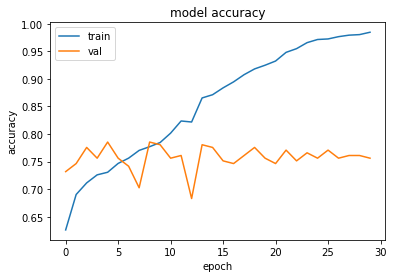

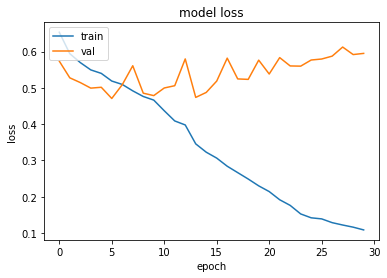

Folder num 31
Genre split [['Hip-Hop', 'Instrumental', 'Folk', 'International'], ['Rock', 'Electronic', 'Experimental', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 15s 88ms/step - loss: 0.6669 - accuracy: 0.6101 - val_loss: 0.6262 - val_accuracy: 0.6537

Epoch 00001: val_accuracy improved from -inf to 0.65366, saving model to ./models/tree_4/model_root/folder31\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6101 - accuracy: 0.6598 - val_loss: 0.6006 - val_accuracy: 0.6976

Epoch 00002: val_accuracy improved from 0.65366 to 0.69756, saving model to ./models/tree_4/model_root/folder31\model.h5
Epoch 3/30
110/110 [==============================] - 9s 80ms/step - loss: 0.6001 - accuracy: 0.6691 - val_loss: 0.5934 - val_accuracy: 0.6732

Epoch 00003: val_accuracy did not improve from 0.69756
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.5782 - accuracy: 0.7002 - val_loss: 0.

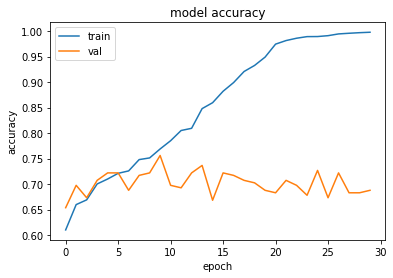

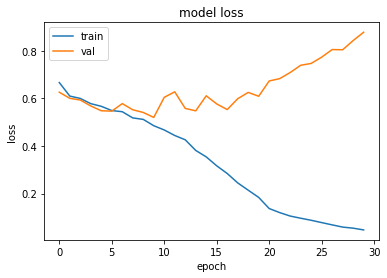

Folder num 32
Genre split [['International', 'Experimental', 'Instrumental', 'Hip-Hop'], ['Folk', 'Rock', 'Electronic', 'Pop']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 16s 88ms/step - loss: 0.6748 - accuracy: 0.5932 - val_loss: 0.6686 - val_accuracy: 0.5951

Epoch 00001: val_accuracy improved from -inf to 0.59512, saving model to ./models/tree_4/model_root/folder32\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6374 - accuracy: 0.6316 - val_loss: 0.6631 - val_accuracy: 0.5805

Epoch 00002: val_accuracy did not improve from 0.59512
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6277 - accuracy: 0.6467 - val_loss: 0.6413 - val_accuracy: 0.6146

Epoch 00003: val_accuracy improved from 0.59512 to 0.61463, saving model to ./models/tree_4/model_root/folder32\model.h5
Epoch 4/30
110/110 [==============================] - 11s 96ms/step - loss: 0.6047 - accuracy: 0.6713 - val_loss: 0

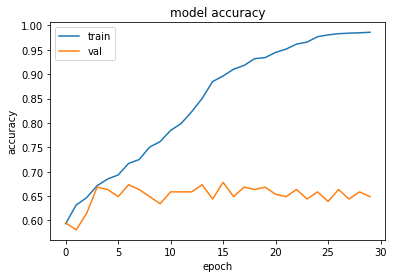

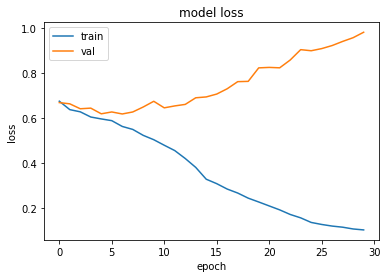

Folder num 33
Genre split [['Hip-Hop', 'International', 'Instrumental', 'Experimental'], ['Pop', 'Rock', 'Electronic', 'Folk']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 18s 130ms/step - loss: 0.6787 - accuracy: 0.5803 - val_loss: 0.6514 - val_accuracy: 0.6049

Epoch 00001: val_accuracy improved from -inf to 0.60488, saving model to ./models/tree_4/model_root/folder33\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6464 - accuracy: 0.6193 - val_loss: 0.6217 - val_accuracy: 0.6634

Epoch 00002: val_accuracy improved from 0.60488 to 0.66341, saving model to ./models/tree_4/model_root/folder33\model.h5
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6210 - accuracy: 0.6570 - val_loss: 0.6153 - val_accuracy: 0.6976

Epoch 00003: val_accuracy improved from 0.66341 to 0.69756, saving model to ./models/tree_4/model_root/folder33\model.h5
Epoch 4/30
110/110 [============================

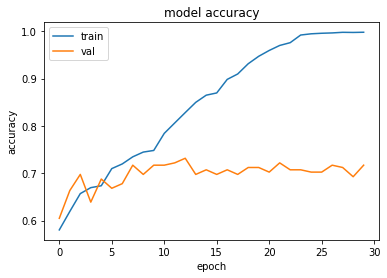

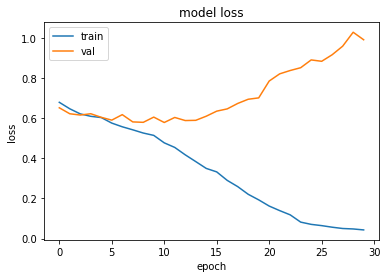

Folder num 34
Genre split [['Electronic', 'Rock', 'International', 'Experimental'], ['Folk', 'Pop', 'Hip-Hop', 'Instrumental']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 13s 89ms/step - loss: 0.6723 - accuracy: 0.5912 - val_loss: 0.6320 - val_accuracy: 0.6439

Epoch 00001: val_accuracy improved from -inf to 0.64390, saving model to ./models/tree_4/model_root/folder34\model.h5
Epoch 2/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6398 - accuracy: 0.6293 - val_loss: 0.7462 - val_accuracy: 0.5171

Epoch 00002: val_accuracy did not improve from 0.64390
Epoch 3/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6373 - accuracy: 0.6301 - val_loss: 0.6226 - val_accuracy: 0.6683

Epoch 00003: val_accuracy improved from 0.64390 to 0.66829, saving model to ./models/tree_4/model_root/folder34\model.h5
Epoch 4/30
110/110 [==============================] - 9s 81ms/step - loss: 0.6084 - accuracy: 0.6596 - val_loss: 0.

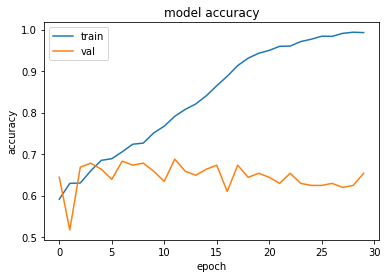

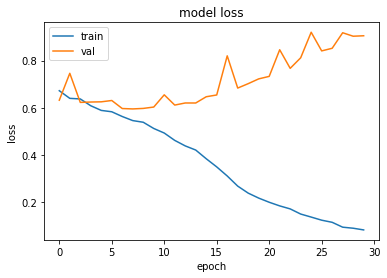

Folder num 35
Genre split [['Hip-Hop', 'Instrumental', 'Electronic', 'International'], ['Rock', 'Experimental', 'Pop', 'Folk']]
Building model...
Training...
Epoch 1/30
110/110 [==============================] - 26s 87ms/step - loss: 0.6606 - accuracy: 0.6163 - val_loss: 0.5760 - val_accuracy: 0.7122

Epoch 00001: val_accuracy improved from -inf to 0.71220, saving model to ./models/tree_4/model_root/folder35\model.h5
Epoch 2/30
110/110 [==============================] - 9s 80ms/step - loss: 0.5954 - accuracy: 0.6892 - val_loss: 0.5490 - val_accuracy: 0.7415

Epoch 00002: val_accuracy improved from 0.71220 to 0.74146, saving model to ./models/tree_4/model_root/folder35\model.h5
Epoch 3/30
110/110 [==============================] - 9s 80ms/step - loss: 0.5666 - accuracy: 0.7088 - val_loss: 0.5130 - val_accuracy: 0.7854

Epoch 00003: val_accuracy improved from 0.74146 to 0.78537, saving model to ./models/tree_4/model_root/folder35\model.h5
Epoch 4/30
110/110 [=============================

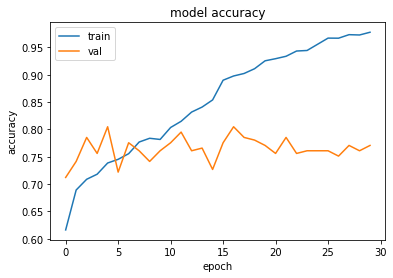

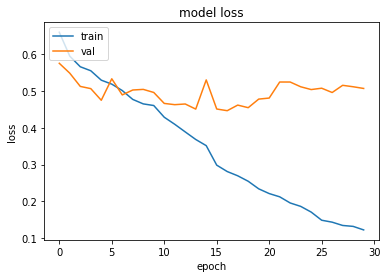

In [15]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 35

kfold = KFold(n_splits=35, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    split = genre_splits[fold_no - 1]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)
    
    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break